In [21]:
import tensorflow as tf
import os
import cv2
import imghdr # In order to find the type(extension) of image
import random # To create the shuffled list of images
from shutil import copyfile # To copy the image files from dataset folder to train,validation split folders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
import numpy as np # To use numpy array
import matplotlib.pyplot as plt # To plot the graphs

Download the DataSet from Kaggle

In [2]:
# Download the dataset from kaggle
os.environ['KAGGLE_USERNAME'] = "cherry260797"
os.environ['KAGGLE_KEY'] = "6b12d843ec65b03b660f9d2ff37f5d09" 
# API Link to download the kaggle dataset
!kaggle datasets download -d maricinnamon/caltech101-airplanes-motorbikes-schooners

 62% 9.00M/14.5M [00:00<00:00, 54.2MB/s]
100% 14.5M/14.5M [00:00<00:00, 79.5MB/s]


In [3]:
# Unzip the downloaded dataset
!unzip caltech101-airplanes-motorbikes-schooners.zip

Archive:  caltech101-airplanes-motorbikes-schooners.zip
  inflating: caltech101_classification/Motorbikes/image_0001.jpg  
  inflating: caltech101_classification/Motorbikes/image_0002.jpg  
  inflating: caltech101_classification/Motorbikes/image_0003.jpg  
  inflating: caltech101_classification/Motorbikes/image_0004.jpg  
  inflating: caltech101_classification/Motorbikes/image_0005.jpg  
  inflating: caltech101_classification/Motorbikes/image_0006.jpg  
  inflating: caltech101_classification/Motorbikes/image_0007.jpg  
  inflating: caltech101_classification/Motorbikes/image_0008.jpg  
  inflating: caltech101_classification/Motorbikes/image_0009.jpg  
  inflating: caltech101_classification/Motorbikes/image_0010.jpg  
  inflating: caltech101_classification/Motorbikes/image_0011.jpg  
  inflating: caltech101_classification/Motorbikes/image_0012.jpg  
  inflating: caltech101_classification/Motorbikes/image_0013.jpg  
  inflating: caltech101_classification/Motorbikes/image_0014.jpg  
  infl

Preprocess the Images

In [4]:
# As a part of pre-processing the data, remove the images not in allowed format
extensions_list=['jpeg','jpg','png']
dataset_path='/content/caltech101_classification'
for folder in os.listdir(dataset_path):
  for current_image in os.listdir(os.path.join(dataset_path,folder)):
    image_path=os.path.join(dataset_path,folder,current_image)
    image=cv2.imread(image_path)
    extension=imghdr.what(image_path)
    if extension not in extensions_list:
      os.remove(image_path)

In [5]:
# Create a directory to split all images into train,dev and test splits and save images in directories
split_directory='/content/splitdir'
os.mkdir(split_directory)

In [6]:
# Create directories for three classes in test, validation and train directories
trainsplit_dir=os.path.join(split_directory,'train')
os.mkdir(trainsplit_dir)
validationsplit_dir=os.path.join(split_directory,'validation')
os.mkdir(validationsplit_dir)
testsplit_dir=os.path.join(split_directory,'test')
os.mkdir(testsplit_dir)

imgclass_list=['Motorbikes','airplanes','schooner']
for imgclass in imgclass_list:
  tdir_path=os.path.join(trainsplit_dir,imgclass)
  vdir_path=os.path.join(validationsplit_dir,imgclass)
  testdir_path=os.path.join(testsplit_dir,imgclass)
  os.mkdir(tdir_path)
  os.mkdir(vdir_path)
  os.mkdir(testdir_path)

In [7]:
#Function to randomly shuffle all the images and divide them into train, valid, test splits and put in pertaining folders
#This function is taken from the provided reference and edited as required.
def data_split(dataset, training, validation,testing, trainsplit_size, valsplit_size):
    files = []
    for filename in os.listdir(dataset):
        file = dataset + filename
        if os.path.getsize(file) > 0:
            files.append(filename)

    trainset_length = int(len(files) * trainsplit_size)
    validset_length = int(len(files) * valsplit_size)
    random_set = random.sample(files, len(files))
    training_set = random_set[0:trainset_length]
    length=trainset_length+validset_length
    valid_set = random_set[trainset_length:length]
    test_set=random_set[length:]

    for filename in training_set:
        current_file = dataset + filename
        destination = training + filename
        copyfile(current_file, destination)

    for filename in valid_set:
        current_file = dataset + filename
        destination = validation + filename
        copyfile(current_file, destination)

    for filename in test_set:
        current_file = dataset + filename
        destination = testing + filename
        copyfile(current_file, destination)

In [8]:
# Call the function defined above to shuffle, split and save images
imgclass_list=['Motorbikes','airplanes','schooner']
for imgclass in imgclass_list:
  class_dataset_dir='/content/caltech101_classification/'+imgclass+'/'
  train_class_dir='/content/splitdir/train/'+imgclass+'/'
  valid_class_dir='/content/splitdir/validation/'+imgclass+'/'
  test_class_dir='/content/splitdir/test/'+imgclass+'/'
  data_split(class_dataset_dir, train_class_dir,test_class_dir, valid_class_dir, .60, .20)

In [9]:
# Check the number of images in each split directory
for i in ['Motorbikes', 'airplanes', 'schooner']:
    print('Training {} images are: '.format(i)+str(len(os.listdir('/content/splitdir/train/'+i+'/'))))
    print('Validation {} images are: '.format(i)+str(len(os.listdir('/content/splitdir/validation/'+i+'/'))))

Training Motorbikes images are: 478
Validation Motorbikes images are: 161
Training airplanes images are: 480
Validation airplanes images are: 160
Training schooner images are: 37
Validation schooner images are: 14


In [10]:
training_directory = '/content/splitdir/train/'
training_imgdata = ImageDataGenerator(rescale = 1/255.0,rotation_range=30,zoom_range=0.4,horizontal_flip=True)

train_generator = training_imgdata.flow_from_directory(training_directory,batch_size=32,class_mode='categorical',target_size=(256, 256))

Found 995 images belonging to 3 classes.


In [11]:
validation_directory = '/content/splitdir/validation'
validation_imgdata = ImageDataGenerator(rescale = 1/255.0)
validation_generator = validation_imgdata.flow_from_directory(validation_directory,batch_size=32,class_mode='categorical',target_size=(256, 256) )

Found 335 images belonging to 3 classes.


In [12]:
testing_directory = '/content/splitdir/test'
testing_imgdata = ImageDataGenerator(rescale = 1/255.0)
test_generator = testing_imgdata.flow_from_directory(testing_directory,batch_size=32,class_mode='categorical',target_size=(256, 256) )

Found 331 images belonging to 3 classes.


Train the Model and check against the Validation split

In [13]:
# This model is built referring the reference provided and observed as the optimal model after experimenting with hyper-parameters of number of layers, image size to start with, batch size of images
model=Sequential()

model.add(Conv2D(16,(3,3), activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3), activation='relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))


In [14]:
model.compile(optimizer='Adam', loss=tf.losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

In [15]:
logdirectory='/content/logs'

In [16]:
os.mkdir(logdirectory)

In [17]:
tensorboard_callback=tf.keras.callbacks.TensorBoard(log_dir=logdirectory)

In [18]:
hist=model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=[tensorboard_callback])

Epoch 1/20
32/32 [==============================] - 78s 2s/step - loss: 0.7369 - accuracy: 0.6583 - val_loss: 0.2236 - val_accuracy: 0.9373
Epoch 2/20
32/32 [==============================] - 84s 3s/step - loss: 0.3545 - accuracy: 0.8714 - val_loss: 0.1238 - val_accuracy: 0.9731
Epoch 3/20
32/32 [==============================] - 75s 2s/step - loss: 0.2075 - accuracy: 0.9357 - val_loss: 0.0563 - val_accuracy: 0.9791
Epoch 4/20
32/32 [==============================] - 78s 2s/step - loss: 0.1687 - accuracy: 0.9477 - val_loss: 0.0311 - val_accuracy: 0.9910
Epoch 5/20
32/32 [==============================] - 78s 2s/step - loss: 0.1181 - accuracy: 0.9628 - val_loss: 0.0187 - val_accuracy: 0.9940
Epoch 6/20
32/32 [==============================] - 79s 2s/step - loss: 0.1814 - accuracy: 0.9407 - val_loss: 0.0388 - val_accuracy: 0.9821
Epoch 7/20
32/32 [==============================] - 86s 3s/step - loss: 0.1065 - accuracy: 0.9658 - val_loss: 0.0664 - val_accuracy: 0.9761
Epoch 8/20
32/32 [==

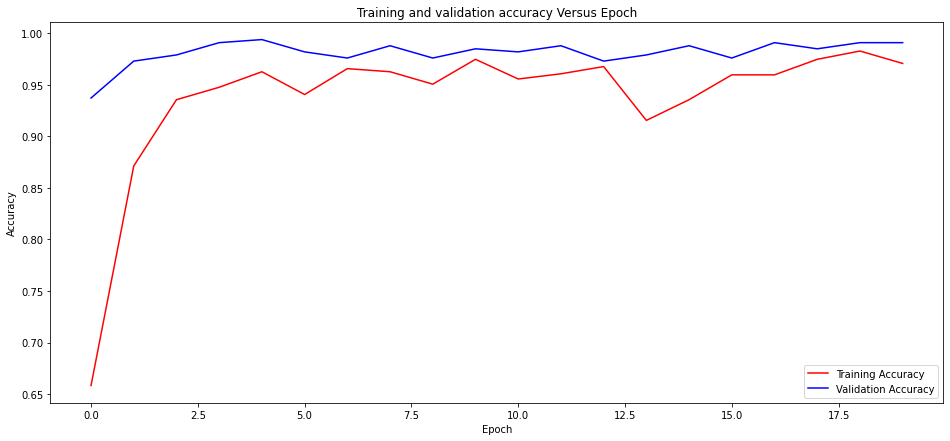

In [23]:
# Plot the graph of training, validation accuracy versus epochs
# This code is taken from reference provided and edited as required.
train_accuracy=hist.history['accuracy']
epochs=range(len(train_accuracy))
validation_accuracy=hist.history['val_accuracy']
train_loss=hist.history['loss']
validation_loss=hist.history['val_loss']

graph1 = plt.figure(figsize=(16,7))
plt.plot(epochs, train_accuracy, 'r', label="Training Accuracy")
plt.plot(epochs, validation_accuracy, 'b', label="Validation Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and validation accuracy Versus Epoch')
plt.legend(loc='lower right')
plt.show()

Text(0.5, 1.0, 'Training and validation loss Versus Epoch')

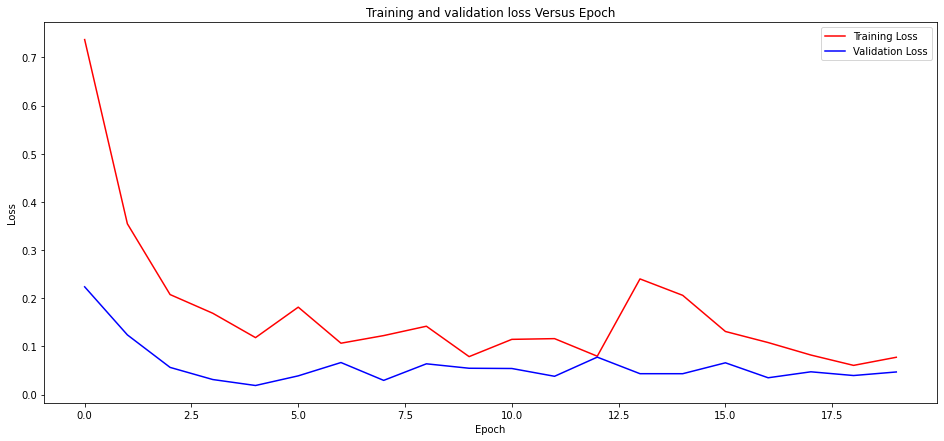

In [24]:
# Plot the graph of training, validation loss versus epochs
# This code is taken from reference provided and edited as required.
graph2 = plt.figure(figsize=(16,7))
plt.plot(epochs, train_loss, 'r', label="Training Loss")
plt.plot(epochs, validation_loss, 'b', label="Validation Loss")
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss Versus Epoch')

Contribution

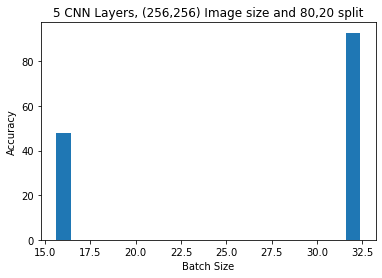

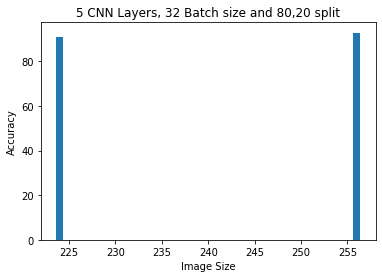

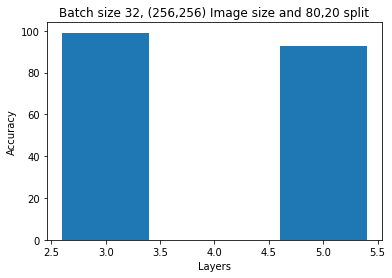

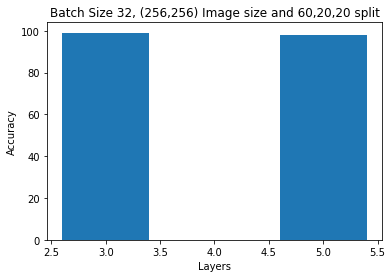

In [28]:
# Provided below are all the hyper-parameters used for experimenting and the validation accuracy in each case.
# Graphs are plotted for provided values.
# When input image size is(256,256), 5 CNN layers are used, with batch size of 16 validation accuracy is 48.05, batch size of 32 it is 92.79.
# When 5 CNN layers are used with batch size of 32, with input image size (224,224), validation accuracy is 98.80 and with (256,256) it is 92.79.
# When input image size is (256,256), batch size 32, following 80,20 split for training and validation with 5 CNN layers validation accuracy is 92.79 and with 3 CNN layers it is 99.10.
# When input image size is (256,256), batch size 32, following 60,20,20 split for training, validation and testing with 5 CNN layers validation accuracy is 98.19 and with 3 CNN layers it is 99.09.
Graph1X=[16,32]
Graph1Y=[48.05,92.79]
plt.bar(Graph1X, Graph1Y)
plt.title('5 CNN Layers, (256,256) Image size and 80,20 split')
plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.show()

Graph2X=[224,256]
Graph2Y=[90.80,92.79]
plt.bar(Graph2X, Graph2Y)
plt.title('5 CNN Layers, 32 Batch size and 80,20 split')
plt.xlabel('Image Size')
plt.ylabel('Accuracy')
plt.show()

Graph3X=[3,5]
Graph3Y=[99.10,92.79]
plt.bar(Graph3X, Graph3Y)
plt.title('Batch size 32, (256,256) Image size and 80,20 split')
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.show()

Graph4X=[3,5]
Graph4Y=[99.09,98.19]
plt.bar(Graph4X, Graph4Y)
plt.title('Batch Size 32, (256,256) Image size and 60,20,20 split')
plt.xlabel('Layers')
plt.ylabel('Accuracy')
plt.show()

Predict the images of Test Directory of splitdir directory

In [27]:
prediction = model.predict(test_generator, batch_size=1, verbose=1)
predicted_labels = np.argmax(array, axis=1)
print(predicted_labels)
# 0 indicates Motorbikes, 1 indicates airplanes and 2 indicates schooner

11/11 [==============================] - 5s 482ms/step
[1 1 0 2 1 1 0 1 0 0 1 1 0 1 0 0 1 0 0 1 0 2 1 0 1 1 0 2 0 1 0 0 1 0 1 1 0
 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 2 1 1 1 2 1 0 1 1 2 0 0 0 0 1 0 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 1 0 2 1 1 1 1 2 0 0 1 1 1 1 1 0 0 1 0 1 0 0 1 0 0 1 1 1
 0 0 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 0 1 1 1 1 0 0 0 0 0 2 0 1 0 2 0 1 0
 1 0 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1
 1 1 0 0 1 1 1 1 1 1 0 1 1 0 1 1 1 0 0 1 0 1 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0
 0 0 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 0 0 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1
 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1
 0 0 2 1 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 1 0 0 1 1 1 0 0]
